In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import backward
import numpy as np
import pickle
from sklearn.utils import shuffle
from tqdm import tqdm
import ipdb

import Utils.util as util

np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

In [2]:
# CRASH_fname = 'CRASH_FE_filtered_subsampled_fmriADJ.pkl'

# with open(CRASH_fname, 'rb') as handle:
#     F_t, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
#     inv_mapping, region_assignment, nTrain, nValid, \
#     nTest, scaler_in, scaler_out = pickle.load(handle)
    
CRASH_fname = 'CRASH_Fonly.pkl'
with open(CRASH_fname, 'rb') as handle:
    F_t, adj_mx, adj_mx_idx, _input, _gt, nTrain, \
    nValid, nTest, scaler_in, scaler_out = pickle.load(handle)


## Testing temporal conv-deconv: only using one node's value across time

(11712, 1, 10) (11712, 1, 10)


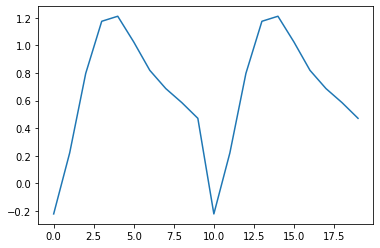

In [3]:
device = 'cuda:0'
# prep data
x = _input[...,0][:,None,:]
y = x
# y = _gt[...,0][:,None,:]
print(x.shape, y.shape)

# plt.plot(x[0,0])
# plt.plot(y[0,0])
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
# y = x
y = torch.tensor(y).to(device)


In [4]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size - 1) * dilation
    return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

# def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs): 
#     ## only pad left (??? pytorch doesn't support)
#     pad = (kernel_size - 1) * dilation
#     return nn.Conv1d(in_channels, out_channels, kernel_size, padding=(pad,0), dilation=dilation, **kwargs)

In [13]:
# tcn & de-tcn model
class tmodel(nn.Module): # for model testing, f in, same f out
    def __init__(self, device='cuda:0', dropout=0.3, in_dim=1,
                residual_channels=32, dilation_channels=32, skip_channels=256,
                end_channels=64, kernel_size=2, blocks=4, layers=2):
        super(tmodel, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.device = device

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.start_conv = nn.Conv1d(in_channels=in_dim,
                                    out_channels=residual_channels,
                                    kernel_size=1)

        receptive_field = 1
        multi_factor = 2
        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))
                self.gate_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=residual_channels,kernel_size=1))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=skip_channels,kernel_size=1))
                self.bn.append(nn.BatchNorm1d(residual_channels))

                new_dilation *= multi_factor
                receptive_field += additional_scope
                additional_scope *= multi_factor


#         ## temporal transConv (de-tcn)
#         convTransK = 2
#         convTransD = 1
#         upScale = 2

#         self.end_module_conv = nn.ModuleList()
#         self.end_module_up = nn.ModuleList()
#         # for b in range(blocks):
#         #     for l in range(layers):
#         for i in range(3):
#             self.end_module_up.append(nn.Upsample(scale_factor=upScale))
#             self.end_module_conv.append(nn.ConvTranspose1d(in_channels=skip_channels, out_channels=residual_channels, 
#                            kernel_size=convTransK, dilation=convTransD))
#         self.end_mlp = nn.Sequential(
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=128, out_channels=16,
#                       kernel_size=1, bias=True),
#             nn.LeakyReLU(),
#             nn.Conv1d(in_channels=16, out_channels=1,
#                       kernel_size=1, bias=True)
#             )
        self.end_conv_1 = nn.Conv1d(skip_channels, end_channels, 1, bias=True)
        self.end_conv_2 = nn.Conv1d(end_channels, 10, 1, bias=True)
#         self.end_conv_3 = nn.Conv1d(10, 1, 1, bias=True)
        
        self.receptive_field = receptive_field

    def forward(self, input, viz=False):
        # inputs: [batch_size, 1, in_len]
        ### deal with supports
        # print(self.receptive_field)
#         in_len = input.size(-1)
#         if in_len<self.receptive_field:
#             x = nn.functional.pad(input,(self.receptive_field-in_len,0))
#         else:
#             x = input
        x = input
        x = self.start_conv(x)

        if viz: # x.shape [16, 32, 15]
            ### plot features on different channels representing the same node fmri signal
            for j in range(x.shape[1]):
                plt.plot(x.detach().cpu().numpy()[0,j,:])
            plt.show()

        skip = 0

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # print(i, x.shape)
            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + --> *input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + -------------> *skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x #[batch_size, residual_dim, 80, 16]

            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter[:, :, :-self.filter_convs[i].padding[0]])
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate[:, :, :-self.gate_convs[i].padding[0]])
            x = filter * gate
#             print(x.shape)
            if i % self.layers == self.layers-1:
                x = F.max_pool1d(x,2)
            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                if s.size(-1)*2 == skip.size(-1):
                    skip = F.max_pool1d(skip,2)
                else:
                    skip = skip[:, :,  -s.size(-1):]
            except:
                skip = 0
            skip = s + skip
            
            x = self.residual_convs[i](x)
            
#             print(residual.shape, x.shape)
            x = x + residual[:, :, -x.size(-1):]
            # x = torch.cat([x, residual[:, :, :, -x.size(3):], t_rep], axis=1)
            x = self.bn[i](x) # comment off for overfitting
            
        # del residual, x
        # skip: [batch_size, hidden_dim, num_nodes, 1]

        # ### test: adding noise to hidden rep
        # skip = skip + torch.normal(torch.zeros_like(skip), 0.1*skip.std()*torch.ones_like(skip))
        # ###
        # x = self.end_module(skip)
        # if viz: # x.shape [16, 512, 200, 1]
        #     # (results look similar) each node's h-D (h being #hidden dim) feature
        #     for j in range(10):
        #         plt.plot(x.detach().cpu().numpy()[0,:,j,0])
        #     plt.show()
        #     # plot each channel's value (on all nodes)
        #     for j in range(10): 
        #         plt.plot(x.detach().cpu().numpy()[0,j,:,0])
        #     plt.show()
        
        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x).transpose(1,2)
        
#         # output a single value
#         x = F.relu(self.end_conv_2(x))
#         x = self.end_conv_3(x.transpose(1,2))
        
#         for i in range(3):#range(self.blocks * self.layers):       
#             x = self.end_module_up[i](x)
#             x = F.relu(self.end_module_conv[i](x))
        
#         x = self.end_mlp(x)
#         # x = self.end_mlp_f(x.transpose(1,3))
        return x

model = tmodel(blocks=3, layers=2).to(device)
print(model)

tmodel(
  (filter_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (gate_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
  )
  (resid

In [14]:
# training & validation
lrate = 1e-4
wdecay = 4e-3
num_epoch = 100
batch_size = 64

print(nTrain, nValid, nTest)
xTrain = x[:nTrain]
xValid = x[nTrain:nTrain+nValid]

yTrain = y[:nTrain]
yValid = y[nTrain:nTrain+nValid]

train_loss = []
val_loss = []
min_val_loss = 1000
obj = nn.MSELoss()
for e in range(num_epoch):
#     if e%20 == 0 and e>0:
#         lrate = lrate * 0.8
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    xTrain, yTrain = shuffle(xTrain, yTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_in = xTrain[i*batch_size:(i+1)*batch_size]
        batch_gt = yTrain[i*batch_size:(i+1)*batch_size]#[:,:,5:6]
        
        out = model(batch_in)
        loss = obj(out, batch_gt)
        cur_loss.append(loss.item())
        
#         if i%150 == 0:
#             print(i, 'loss', loss.item(), 'mape', util.masked_mape(out, batch_gt,0).item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', np.mean(cur_loss))
    # validate each epoch
    model.eval()
    with torch.no_grad():
        out = model(xValid)
    loss = obj(out, yValid)#[:,:,5:6])
    val_loss.append(loss.item())
    if loss.item() < min_val_loss:
        min_val_loss = loss.item()
        torch.save(model.state_dict(), "garage/exp_t.pth")
    print('val loss', loss.item(), 'mape', util.masked_mape(out, yValid,0).item())


  4%|▍         | 5/128 [00:00<00:02, 47.11it/s]

8198 1757 1757


  5%|▍         | 6/128 [00:00<00:02, 51.75it/s]

epoch 0 train loss 0.6539309592917562
val loss 0.3799901008605957 mape 0.14023929834365845


  4%|▍         | 5/128 [00:00<00:02, 48.49it/s]

epoch 1 train loss 0.2959155486896634
val loss 0.22415630519390106 mape 0.10275031626224518


  5%|▍         | 6/128 [00:00<00:02, 57.73it/s]

epoch 2 train loss 0.1893482196610421
val loss 0.14371061325073242 mape 0.01836537756025791


  5%|▍         | 6/128 [00:00<00:02, 51.35it/s]

epoch 3 train loss 0.1286864370922558
val loss 0.09591345489025116 mape 0.1101529449224472


  5%|▍         | 6/128 [00:00<00:02, 52.61it/s]

epoch 4 train loss 0.09248354006558657
val loss 0.06944939494132996 mape -0.010365464724600315


  5%|▍         | 6/128 [00:00<00:02, 50.98it/s]

epoch 5 train loss 0.07458920069620945
val loss 0.05435238778591156 mape -0.02566368132829666


  5%|▍         | 6/128 [00:00<00:02, 51.48it/s]

epoch 6 train loss 0.06145653658313677
val loss 0.044220272451639175 mape -0.02694866620004177


  5%|▍         | 6/128 [00:00<00:02, 50.84it/s]

epoch 7 train loss 0.053748289501527324
val loss 0.03766375780105591 mape -0.0042729158885777


  5%|▍         | 6/128 [00:00<00:02, 50.71it/s]

epoch 8 train loss 0.04726030497113243
val loss 0.032808367162942886 mape 0.01921679638326168


  5%|▍         | 6/128 [00:00<00:02, 51.53it/s]

epoch 9 train loss 0.041275008115917444
val loss 0.027949700132012367 mape -0.012544992379844189


  5%|▍         | 6/128 [00:00<00:02, 52.74it/s]

epoch 10 train loss 0.036876128942822106
val loss 0.023061638697981834 mape -0.00019510580750647932


  4%|▍         | 5/128 [00:00<00:02, 49.92it/s]

epoch 11 train loss 0.029942418390419334
val loss 0.01964598335325718 mape -0.005217813886702061


  5%|▍         | 6/128 [00:00<00:02, 51.56it/s]

epoch 12 train loss 0.028280692298721988
val loss 0.01767568476498127 mape -0.009020783007144928


  5%|▍         | 6/128 [00:00<00:02, 50.75it/s]

epoch 13 train loss 0.027073714751168154
val loss 0.015757860615849495 mape 0.002745379228144884


  5%|▍         | 6/128 [00:00<00:02, 51.23it/s]

epoch 14 train loss 0.025522675467072986
val loss 0.015591335482895374 mape -0.006340415216982365


  5%|▍         | 6/128 [00:00<00:02, 51.59it/s]

epoch 15 train loss 0.024428290358628146
val loss 0.014848390594124794 mape 0.004901037085801363


  5%|▍         | 6/128 [00:00<00:02, 50.72it/s]

epoch 16 train loss 0.023285638308152556
val loss 0.015024418942630291 mape -0.03159377723932266


  5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

epoch 17 train loss 0.0232245096412953
val loss 0.013876176439225674 mape 0.01392548717558384


  5%|▍         | 6/128 [00:00<00:02, 51.45it/s]

epoch 18 train loss 0.0232385848503327
val loss 0.013661134988069534 mape -0.03157415613532066


  5%|▍         | 6/128 [00:00<00:02, 51.69it/s]

epoch 19 train loss 0.02214098743570503
val loss 0.015782760456204414 mape -0.03400092571973801


  5%|▍         | 6/128 [00:00<00:02, 50.96it/s]

epoch 20 train loss 0.021706247942347545
val loss 0.014321382157504559 mape 0.020166529342532158


  5%|▍         | 6/128 [00:00<00:02, 51.24it/s]

epoch 21 train loss 0.0208272317686351
val loss 0.013105210848152637 mape -0.024552324786782265


  5%|▍         | 6/128 [00:00<00:02, 51.65it/s]

epoch 22 train loss 0.02039682921167696
val loss 0.013000098057091236 mape 0.0013082227669656277


  5%|▍         | 6/128 [00:00<00:02, 49.98it/s]

epoch 23 train loss 0.020105924646486528
val loss 0.013079661875963211 mape -0.01677463762462139


  5%|▍         | 6/128 [00:00<00:02, 51.62it/s]

epoch 24 train loss 0.02099129240377806
val loss 0.015409893356263638 mape -0.013285753317177296


  5%|▍         | 6/128 [00:00<00:02, 51.22it/s]

epoch 25 train loss 0.020545444102026522
val loss 0.012959722429513931 mape 0.001378303742967546


  5%|▍         | 6/128 [00:00<00:02, 51.72it/s]

epoch 26 train loss 0.02024642137985211
val loss 0.012003343552350998 mape -0.002801574533805251


  5%|▍         | 6/128 [00:00<00:02, 51.54it/s]

epoch 27 train loss 0.019507610028085764
val loss 0.01282819826155901 mape -0.015062814578413963


  5%|▍         | 6/128 [00:00<00:02, 51.05it/s]

epoch 28 train loss 0.019269867247203365
val loss 0.014377329498529434 mape -0.0005169819924049079


  5%|▍         | 6/128 [00:00<00:02, 52.63it/s]

epoch 29 train loss 0.01931412964768242
val loss 0.01297976728528738 mape 0.0037815135437995195


  5%|▍         | 6/128 [00:00<00:02, 51.45it/s]

epoch 30 train loss 0.019551640645659063
val loss 0.01195405051112175 mape -0.009441477246582508


  5%|▍         | 6/128 [00:00<00:02, 51.10it/s]

epoch 31 train loss 0.019672825030284002
val loss 0.01281119603663683 mape -0.029042648151516914


  5%|▍         | 6/128 [00:00<00:02, 51.44it/s]

epoch 32 train loss 0.01975286830565892
val loss 0.013295244425535202 mape 0.01898009516298771


  5%|▍         | 6/128 [00:00<00:02, 50.94it/s]

epoch 33 train loss 0.018802793529175688
val loss 0.011925681494176388 mape -0.01191501971334219


  4%|▍         | 5/128 [00:00<00:02, 49.93it/s]

epoch 34 train loss 0.018811412090144586
val loss 0.011700526811182499 mape 0.0001859574840636924


  5%|▍         | 6/128 [00:00<00:02, 51.02it/s]

epoch 35 train loss 0.018447651134920307
val loss 0.011831666342914104 mape 0.01412511058151722


  5%|▍         | 6/128 [00:00<00:02, 50.68it/s]

epoch 36 train loss 0.01870055016479455
val loss 0.01125197485089302 mape 0.0017661878373473883


  5%|▍         | 6/128 [00:00<00:02, 51.80it/s]

epoch 37 train loss 0.018117407569661736
val loss 0.011971519328653812 mape -0.00666228448972106


  5%|▍         | 6/128 [00:00<00:02, 52.06it/s]

epoch 38 train loss 0.018419361764244968
val loss 0.012062535621225834 mape 0.01165599562227726


  5%|▍         | 6/128 [00:00<00:02, 50.93it/s]

epoch 39 train loss 0.018272578417963814
val loss 0.011797414161264896 mape 0.00675343070179224


  5%|▍         | 6/128 [00:00<00:02, 51.85it/s]

epoch 40 train loss 0.018019231600192143
val loss 0.011296218261122704 mape 0.017909595742821693


  5%|▍         | 6/128 [00:00<00:02, 51.54it/s]

epoch 41 train loss 0.017678066458756803
val loss 0.01075746864080429 mape 0.007230529561638832


  5%|▍         | 6/128 [00:00<00:02, 51.96it/s]

epoch 42 train loss 0.0173851656181796
val loss 0.011185510084033012 mape 0.016590647399425507


  5%|▍         | 6/128 [00:00<00:02, 51.89it/s]

epoch 43 train loss 0.01743232754233759
val loss 0.011387751437723637 mape 0.027991579845547676


  5%|▍         | 6/128 [00:00<00:02, 51.65it/s]

epoch 44 train loss 0.017286525722738588
val loss 0.013746349141001701 mape 0.017034506425261497


  5%|▍         | 6/128 [00:00<00:02, 51.02it/s]

epoch 45 train loss 0.017527802629047073
val loss 0.010945349000394344 mape -0.008814754895865917


  5%|▍         | 6/128 [00:00<00:02, 52.62it/s]

epoch 46 train loss 0.017589213995961472
val loss 0.01104367058724165 mape 0.03853417932987213


  5%|▍         | 6/128 [00:00<00:02, 50.41it/s]

epoch 47 train loss 0.01663733414898161
val loss 0.013869893737137318 mape 0.016745688393712044


  5%|▍         | 6/128 [00:00<00:02, 52.46it/s]

epoch 48 train loss 0.017120233314926736
val loss 0.011277440935373306 mape -0.001959634944796562


  5%|▍         | 6/128 [00:00<00:02, 51.27it/s]

epoch 49 train loss 0.017909132711793063
val loss 0.011564178392291069 mape 0.016463447362184525


  5%|▍         | 6/128 [00:00<00:02, 51.77it/s]

epoch 50 train loss 0.01702574810042279
val loss 0.010617492720484734 mape 0.021762393414974213


  5%|▍         | 6/128 [00:00<00:02, 51.38it/s]

epoch 51 train loss 0.01663687809923431
val loss 0.0120638906955719 mape 0.0253410954028368


  5%|▍         | 6/128 [00:00<00:02, 51.93it/s]

epoch 52 train loss 0.016835862450534478
val loss 0.011716969311237335 mape 0.01116247195750475


  5%|▍         | 6/128 [00:00<00:02, 51.24it/s]

epoch 53 train loss 0.016140065854415298
val loss 0.01088127214461565 mape 0.007737128529697657


  5%|▍         | 6/128 [00:00<00:02, 51.82it/s]

epoch 54 train loss 0.01672563116881065
val loss 0.01114873681217432 mape 0.034725677222013474


  5%|▍         | 6/128 [00:00<00:02, 50.89it/s]

epoch 55 train loss 0.015854748438869137
val loss 0.010644683614373207 mape 0.03341982513666153


  5%|▍         | 6/128 [00:00<00:02, 50.55it/s]

epoch 56 train loss 0.016532188528799452
val loss 0.011064618825912476 mape 0.003697851672768593


  5%|▍         | 6/128 [00:00<00:02, 52.44it/s]

epoch 57 train loss 0.016648324228299316
val loss 0.011327656917273998 mape 0.015307278372347355


  5%|▍         | 6/128 [00:00<00:02, 50.40it/s]

epoch 58 train loss 0.015739631049655145
val loss 0.009948723949491978 mape 0.018949098885059357


  5%|▍         | 6/128 [00:00<00:02, 52.22it/s]

epoch 59 train loss 0.0160861900949385
val loss 0.010379265993833542 mape 0.01632479950785637


  5%|▍         | 6/128 [00:00<00:02, 51.76it/s]

epoch 60 train loss 0.015968254876497667
val loss 0.011585094034671783 mape 0.02653336152434349


  5%|▍         | 6/128 [00:00<00:02, 51.61it/s]

epoch 61 train loss 0.015544628782663494
val loss 0.010310090146958828 mape 0.027805719524621964


  5%|▍         | 6/128 [00:00<00:02, 52.73it/s]

epoch 62 train loss 0.01644626439883723
val loss 0.010067097842693329 mape 0.0012636135797947645


  4%|▍         | 5/128 [00:00<00:02, 49.78it/s]

epoch 63 train loss 0.016151734336744994
val loss 0.010717685334384441 mape 0.020964639261364937


  5%|▍         | 6/128 [00:00<00:02, 55.01it/s]

epoch 64 train loss 0.015997792208509054
val loss 0.010024923831224442 mape 0.018167544156312943


  5%|▍         | 6/128 [00:00<00:02, 52.57it/s]

epoch 65 train loss 0.015686202175857034
val loss 0.010391628369688988 mape 0.025311553850769997


  5%|▍         | 6/128 [00:00<00:02, 54.42it/s]

epoch 66 train loss 0.01650406629050849
val loss 0.011392936110496521 mape 0.03268967941403389


  5%|▍         | 6/128 [00:00<00:02, 51.85it/s]

epoch 67 train loss 0.015559181018033996
val loss 0.010807368904352188 mape 0.03796561062335968


  5%|▍         | 6/128 [00:00<00:02, 52.04it/s]

epoch 68 train loss 0.015219433349557221
val loss 0.011817567981779575 mape 0.028496405109763145


  5%|▍         | 6/128 [00:00<00:02, 52.18it/s]

epoch 69 train loss 0.015720762523415033
val loss 0.010218278504908085 mape 0.00630596000701189


  5%|▍         | 6/128 [00:00<00:02, 51.76it/s]

epoch 70 train loss 0.015458109690371202
val loss 0.010619690641760826 mape 0.045016128569841385


  5%|▍         | 6/128 [00:00<00:02, 51.78it/s]

epoch 71 train loss 0.015599447735439753
val loss 0.01276018749922514 mape 0.003400561399757862


  5%|▍         | 6/128 [00:00<00:02, 51.46it/s]

epoch 72 train loss 0.015210531499178614
val loss 0.010319394990801811 mape 0.007430573459714651


  5%|▍         | 6/128 [00:00<00:02, 55.41it/s]

epoch 73 train loss 0.01547301371829235
val loss 0.010217860341072083 mape 0.0100451884791255


  5%|▍         | 6/128 [00:00<00:02, 51.43it/s]

epoch 74 train loss 0.015999025759811047
val loss 0.01062737312167883 mape 0.02649644948542118


  5%|▍         | 6/128 [00:00<00:02, 51.59it/s]

epoch 75 train loss 0.015109829862922197
val loss 0.01078794989734888 mape 0.00597235094755888


  5%|▍         | 6/128 [00:00<00:02, 50.42it/s]

epoch 76 train loss 0.015276186655682977
val loss 0.009957635775208473 mape 0.017455222085118294


  5%|▍         | 6/128 [00:00<00:02, 50.83it/s]

epoch 77 train loss 0.015814726899407106
val loss 0.010475155897438526 mape 0.0039024599827826023


  5%|▍         | 6/128 [00:00<00:02, 51.90it/s]

epoch 78 train loss 0.01536903649684973
val loss 0.010948045179247856 mape 0.008898237720131874


  5%|▍         | 6/128 [00:00<00:02, 50.50it/s]

epoch 79 train loss 0.015127245296753244
val loss 0.010555299930274487 mape -0.019891245290637016


  5%|▍         | 6/128 [00:00<00:02, 51.81it/s]

epoch 80 train loss 0.01608220274647465
val loss 0.01103357132524252 mape 0.020325535908341408


  5%|▍         | 6/128 [00:00<00:02, 51.60it/s]

epoch 81 train loss 0.015274804325599689
val loss 0.009971448220312595 mape 0.003203056985512376


  5%|▍         | 6/128 [00:00<00:02, 51.62it/s]

epoch 82 train loss 0.014901033548085252
val loss 0.010631718672811985 mape 0.0024143329355865717


  5%|▍         | 6/128 [00:00<00:02, 52.13it/s]

epoch 83 train loss 0.015258669125614688
val loss 0.010349712334573269 mape 0.02311042696237564


  5%|▍         | 6/128 [00:00<00:02, 51.43it/s]

epoch 84 train loss 0.014372880305018043
val loss 0.009816068224608898 mape 0.01860520988702774


  5%|▍         | 6/128 [00:00<00:02, 51.40it/s]

epoch 85 train loss 0.01488681726186769
val loss 0.010106445290148258 mape 0.013686343096196651


  5%|▍         | 6/128 [00:00<00:02, 51.06it/s]

epoch 86 train loss 0.015406552513013594
val loss 0.0100893909111619 mape 0.021777847781777382


  5%|▍         | 6/128 [00:00<00:02, 52.72it/s]

epoch 87 train loss 0.015184582116489764
val loss 0.011675463058054447 mape 0.03723202273249626


  5%|▍         | 6/128 [00:00<00:02, 52.56it/s]

epoch 88 train loss 0.01501379791443469
val loss 0.009889183565974236 mape -0.006917593069374561


  5%|▍         | 6/128 [00:00<00:02, 52.25it/s]

epoch 89 train loss 0.015223651920678094
val loss 0.010916638188064098 mape -0.0025933270808309317


  5%|▍         | 6/128 [00:00<00:02, 50.65it/s]

epoch 90 train loss 0.014472841106908163
val loss 0.00997955072671175 mape 0.023823337629437447


  5%|▍         | 6/128 [00:00<00:02, 50.81it/s]

epoch 91 train loss 0.014542078723025043
val loss 0.010453124530613422 mape 0.0018036218825727701


  5%|▍         | 6/128 [00:00<00:02, 52.64it/s]

epoch 92 train loss 0.015398511997773312
val loss 0.010095491074025631 mape 0.014193282462656498


  5%|▍         | 6/128 [00:00<00:02, 51.31it/s]

epoch 93 train loss 0.01432193951040972
val loss 0.00931827537715435 mape 0.014547085389494896


  5%|▍         | 6/128 [00:00<00:02, 51.99it/s]

epoch 94 train loss 0.015015153505373746
val loss 0.009534930810332298 mape 0.015041015110909939


  5%|▍         | 6/128 [00:00<00:02, 51.50it/s]

epoch 95 train loss 0.015269899395207176
val loss 0.01021640095859766 mape 0.015840094536542892


  5%|▍         | 6/128 [00:00<00:02, 50.78it/s]

epoch 96 train loss 0.014077270643610973
val loss 0.009912333451211452 mape -0.012612183578312397


  5%|▍         | 6/128 [00:00<00:02, 51.85it/s]

epoch 97 train loss 0.014711957006511511
val loss 0.011094260029494762 mape 0.05893322080373764


  5%|▍         | 6/128 [00:00<00:02, 51.60it/s]

epoch 98 train loss 0.015004245928139426
val loss 0.00933352392166853 mape -0.000258077634498477


100%|██████████| 128/128 [00:02<00:00, 51.15it/s]

epoch 99 train loss 0.01455972757685231
val loss 0.009562883526086807 mape 0.00831862073391676


min train loss 0.014077270643610973 min val loss 0.00931827537715435


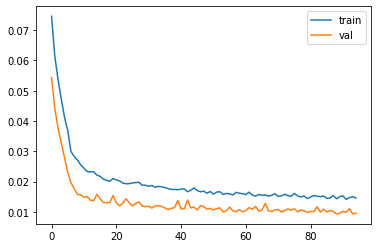

In [15]:
# plot loss curve
print('min train loss', min(train_loss), 'min val loss', min(val_loss))
plt.plot(train_loss[5:], label='train')
plt.plot(val_loss[5:], label='val')
plt.legend()
plt.show()

### Recursively predicting the next frame

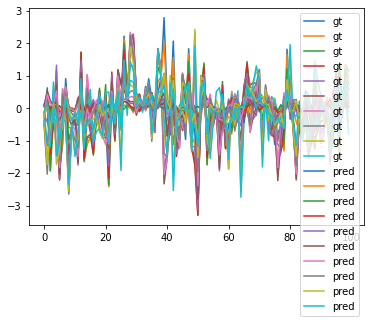

In [83]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]
model.eval()
with torch.no_grad():
    test_out = model(xTest).detach().cpu().numpy().squeeze()

plt.plot(yTest[:100].detach().cpu().numpy(), label='gt')
# plt.plot(yTest[:,5:6][:100].detach().cpu().numpy(), label='gt')
plt.plot(test_out[:100], label='pred')
# plt.plot(xTest[:,0,-1][:100].detach().cpu().numpy().squeeze(), label='last input value')
plt.legend()

In [90]:
cur_in = xTest
pred = []

with torch.no_grad():
    for i in range(10):
        cur_out = model(cur_in)
        pred.append(cur_out)
        cur_in = torch.cat((cur_in, cur_out), 2)[:,:,1:]

pred = torch.cat(pred, 2).squeeze()
print(pred.shape, yTest.shape)
print('mape:', util.masked_mape(pred, yTest,0).item(), 'cc', util.get_cc(pred, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(pred[k].detach().cpu().numpy(), color='r')
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Got 10 and 1 (The offending index is 0)

### observations
predict near future converges immediately, but predicting further-away frames need much more epochs

### Directly mapping / predicting t frames

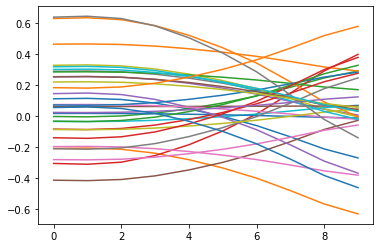

torch.Size([1757, 10]) torch.Size([1757, 10])
mape: -0.08154258877038956 cc 0.9952195499756448


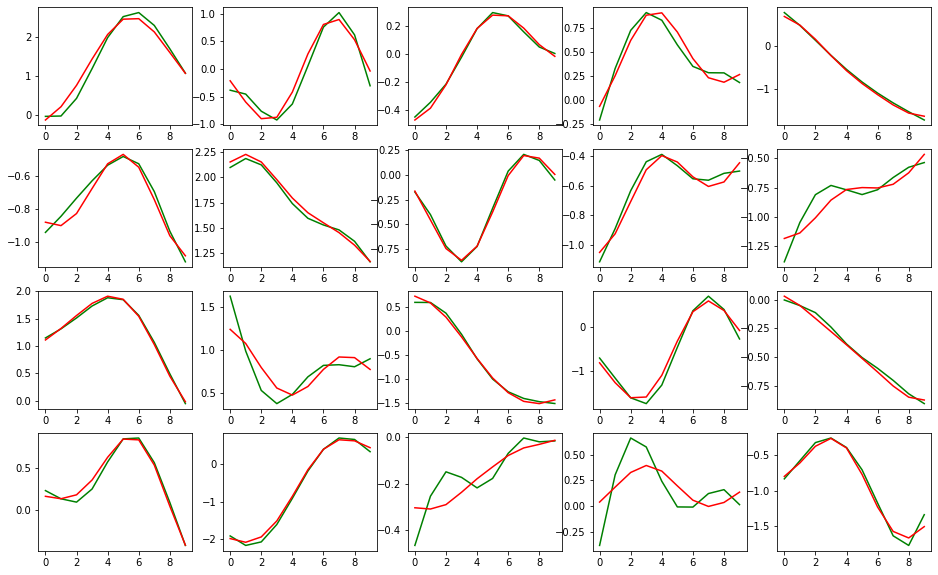

In [16]:
# test
yTest = y[-nTest:].squeeze()
xTest = x[-nTest:]

model.eval()
with torch.no_grad():
    test_out = model(xTest, viz=True).squeeze()

print(yTest.shape, test_out.shape)
print('mape:', util.masked_mape(test_out, yTest,0).item(), 'cc', util.get_cc(test_out, yTest)[0])

i_num = 4
j_num = 5
plt.figure(figsize=(16,10))
for i in range(i_num):
    for j in range(j_num):
        k = i*j_num+j+1
#         print(k)
        plt.subplot(i_num, j_num, k)
        plt.plot(yTest[k].detach().cpu().numpy(), color='g')
        plt.plot(test_out[k].detach().cpu().numpy(), color='r')
plt.show()

### Observations
Mapping is good

### t branches, each predict one future step. 
Also more weight on recent pred (otherwise further-away loss is dominating)

(Give up, since for the real problem EEG has so many frames, this isn't quite practical)

##  Testing spatial conv-deconv: only using one time frame's value on all nodes

In [ ]:
device = 'cuda:0'
# prep data
x = _input[...,0][:,None,:]
y = x
# y = _gt[...,0][:,None,:]
print(x.shape, y.shape)

# plt.plot(x[0,0])
# plt.plot(y[0,0])
plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
# y = x
y = torch.tensor(y).to(device)
